In [1]:
!pip install -q --upgrade pip
!pip install -U jaxlib==0.4.2+cuda11.cudnn82 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q --upgrade jax[cuda11_cudnn805] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q git+https://www.github.com/google/neural-tangents
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cpu
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cpu.html


In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Masterarbeit/two_WL_NTK

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Masterarbeit/two_WL_NTK


In [6]:
from utils import *
import os

from sklearn import metrics
import neural_tangents as nt
from neural_tangents import stax
from jax import numpy as np
from jax import random
import jax
from jax import numpy as np
from jax import jit, grad, vmap
from jax.example_libraries import optimizers
from jax import random
import matplotlib.pyplot as plt
from jax.nn import log_softmax
from data_preperation import *
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

In [7]:
def balance(ys):
  one_indices = np.array(np.nonzero(ys))[0,:]
  zero_indices = np.array(np.nonzero(ys==0))[0,:]

  one_count = int(one_indices.shape[0])
  zero_count = int(zero_indices.shape[0])

  if one_count > zero_count:
    one_indices = one_indices[:zero_count]
  else:
    zero_indices = zero_indices[:one_count]

  indices = np.append(one_indices, zero_indices)

  # shuffel the indices
  key = random.PRNGKey(0)
  key, subkey = jax.random.split(key)
  indices = random.permutation(subkey, indices)

  return indices

In [95]:
dataset = TUDataset(root="Masterarbeit", name="MUTAG")

In [96]:
# make lists of edge indices, node feature and y
edge_indexs = list()
graps_node_features = list()
ys = list()
for data in dataset:
    edge_indexs.append(data.edge_index)
    graps_node_features.append(np.array(data.x))
    ys.append(np.array(data.y))

nb_graphs = len(graps_node_features)
max_edges = max([x.shape[1] for x in edge_indexs])
max_nodes = len(max(graps_node_features, key=lambda x: len(x)))

edge_indexs = np.array([zero_append(x, (2,max_edges))  for x in edge_indexs])

graps_node_features = [zero_append(ef, (max_nodes, ef.shape[1])) for ef in graps_node_features]
graps_node_features = np.expand_dims(np.array(graps_node_features), 3)

ys = np.array(ys)

print(edge_indexs.shape)
print(graps_node_features.shape)
print(ys.shape)

(188, 2, 66)
(188, 28, 7, 1)
(188, 1)


When using the sparse implementation of aggreagtion layyer the pattern needs to be of shape batch x #edges x 1 x 2.

Node Features need to be of shape:
batch x #nodes x 1 x Channels

In [97]:
pattern = np.swapaxes(edge_indexs, 1,2)
pattern = np.expand_dims(pattern, 2)
pattern = np.array(pattern, dtype="int32")

x = np.swapaxes(graps_node_features, 2,3)

print(pattern.shape)
print(x.shape)

(188, 66, 1, 2)
(188, 28, 1, 7)


In [98]:
# split the data into folds for cross validation
key = random.PRNGKey(0)
key, subkey = jax.random.split(key)
batch_index = np.squeeze(random.randint(subkey, (188,1), 0, 10))

In [132]:
layer_wide = 16
# define a grap convolution network
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Aggregate(aggregate_axis=1, batch_axis=0, channel_axis=3, implementation="SPARSE"),
    stax.Conv(layer_wide, (1,1), parameterization="standard"), stax.Relu(),
    stax.Aggregate(aggregate_axis=1, batch_axis=0, channel_axis=3, implementation="SPARSE"),
    stax.Conv(layer_wide, (1,1), parameterization="standard"), stax.Relu(),
    stax.GlobalSumPool(),
    stax.Dense(1),
)

/usr/local/lib/python3.8/dist-packages/neural_tangents/_src/stax/linear.py:439: UserWarning: Negative indices in `pattern` are considered as padding (i.e. ignored), unlike typical numpy negative indexing.
  warnings.warn('Negative indices in `pattern` are considered as padding '


In [100]:
def accuracy(ys, logits):
  return np.mean((logits > 0) == ys)

def cross_entropy(ys, logits):
  log_p = jax.nn.log_sigmoid(logits)
  log_not_p = jax.nn.log_sigmoid(-logits)
  return np.mean(-ys * log_p - (1 - ys) * log_not_p)

loss = jit(cross_entropy)
grad_loss = jit(grad(lambda params, x, y, pattern: loss(y, apply_fn(params, x, pattern=pattern))))

In [133]:
# initialize the paramters and the optimzer 
learning_rate =  0.0005

key, subkey = jax.random.split(key)
_, params = init_fn(subkey, x.shape)

opt_init, opt_apply, get_params = optimizers.adam(learning_rate)
opt_apply = jit(opt_apply)
state = opt_init(params)

In [134]:
epochs = 100

train_losses = []
val_losses = []
params_evolution = []
val_acc = []

for epoch in range(epochs):

  key, subkey = jax.random.split(key)
  hold_out_batch = np.squeeze(random.randint(subkey, (1,1), 0, 10))
  hold_out_indx = hold_out_batch == batch_index

  xs_val = x[hold_out_indx,:]
  pattern_val = pattern[hold_out_indx,:]
  ys_val = ys[hold_out_indx,:]

  xs_train = x[~hold_out_indx,:]
  pattern_train = pattern[~hold_out_indx,:]
  ys_train = ys[~hold_out_indx,:]

  # balance the classes for the training
  balanced_indices_train = balance(ys_train)
  xs_train = xs_train[balanced_indices_train,:]
  pattern_train = pattern_train[balanced_indices_train,:]
  ys_train = ys_train[balanced_indices_train,:]

  params = get_params(state)
  params_evolution.append(params)
  state = opt_apply(epoch, grad_loss(params, xs_train, ys_train, pattern_train), state)

  params = get_params(state)
  train_losses += [loss(ys_train, apply_fn(params, xs_train, pattern=pattern_train))]
  val_losses += [loss(ys_val, apply_fn(params, xs_val, pattern=pattern_val))]
  #val_auc += [metrics.roc_auc_score(ys_val, apply_fn(params, xs_val, pattern=pattern_val))]
  val_acc += [accuracy(ys_val, apply_fn(params, xs_val, pattern=pattern_val))]

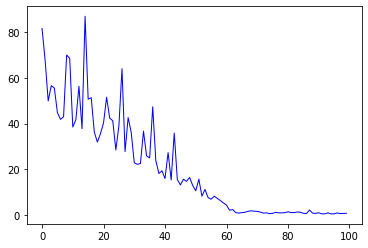

In [135]:
plt.plot(np.array(range(epochs)), np.array(val_losses), 'b-', linewidth=1)

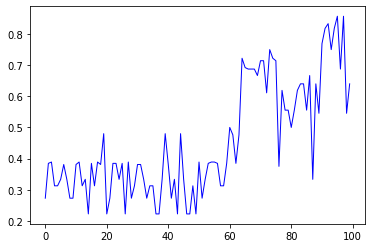

In [136]:
plt.plot(np.array(range(epochs)), np.array(val_acc), 'b-', linewidth=1)

In [137]:
np.mean(np.array(val_acc[-10:]))

Array(0.7576168, dtype=float32)

In [138]:
jax.nn.sigmoid(apply_fn(params, xs_val, pattern=pattern_val))

Array([[0.04885494],
       [0.2007486 ],
       [0.42893782],
       [0.69411683],
       [0.97135675],
       [0.08074962],
       [0.22871457],
       [0.14324293],
       [0.42396846],
       [0.4316684 ],
       [0.95276123],
       [0.18396212],
       [0.13454477],
       [0.42894062],
       [0.18414317],
       [0.12212349],
       [0.01204742],
       [0.05009267],
       [0.4242573 ],
       [0.99638355],
       [0.02494285],
       [0.805325  ],
       [0.80502874],
       [0.03352764],
       [0.1334655 ]], dtype=float32)